# Athlete Trend Extraction
Extract some common trends for each athlete in the dataset. That data can then be used to fill a UI where an athlete's trends can be looked up.

In [1]:
import pandas as pd
import numpy as np

In [2]:
full_rounds = pd.read_csv('data/scraped/cleaned/rounds_splits.csv')

# replace 0 positions and laptimes with NaN
pos_cols = [f'lap_{x}_position' for x in range(1, 46)]
laptime_cols = [f'lap_{x}_laptime' for x in range(1, 46)]
full_rounds[pos_cols] = full_rounds[pos_cols].replace(0.0, np.nan)
full_rounds[laptime_cols] = full_rounds[laptime_cols].replace(0.0, np.nan)

C:\Users\ahale\Anaconda3\envs\shorttrack\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (15,19,20,22,23,25,26,28,29,31,34,37,40,43,46,47,49,50,52,53,55,56,58,59,62,65,68,71,74,77,80,83,86,89,92,95,98,101,104,107,109,110,113,116,119,122,125,128,131,134,137,140,143,146,149,151,152) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
individual_events = full_rounds[full_rounds['event'].isin({'500m', '1000m', '1500m'})]

In [4]:
individual_events.Name.value_counts()

HAMELINCharles        693
AriannaFONTANA        663
NicolaRODIGARI        659
EvgeniaRADANOVA       650
KaterinaNOVOTNA       634
                     ... 
YoshieTOMATSU           1
SOKOLOVMikhail          1
BrendanRonaldCOREY      1
DEJONGHEGeert           1
TALBOTKristen           1
Name: Name, Length: 2267, dtype: int64

Select one athlete with a many races to complete the experiments below.

In [5]:
athlete_races = individual_events[individual_events['Name'] == 'KaterinaNOVOTNA']

## Most Common Position to Start the Race

event
1000m    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1500m    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
500m     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

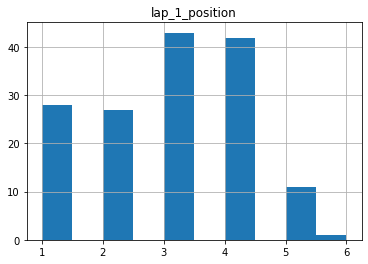

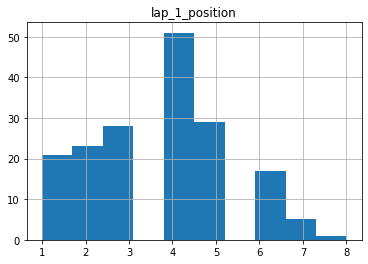

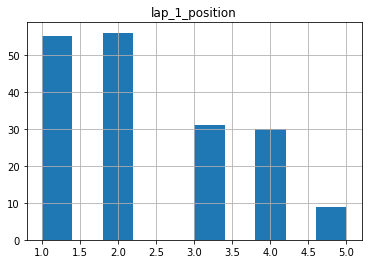

In [6]:
athlete_races[['event', 'lap_1_position']].groupby('event').hist()

## 500m Half-Lap Start Time
TODO: Should throw out significant outliers (e.g. if athlete fell in the first half-lap) 

In [8]:
start_times = athlete_races[(athlete_races['event'] == '500m')]['lap_1_laptime'].astype('float')
start_times.mean()

7.6442499999999995

<AxesSubplot:>

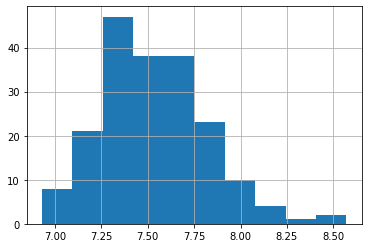

In [10]:
start_times[start_times < 9].hist()

## 500m Start Performance
Does the athlete get especially good starts from a particular position on the line?   
TODO: should throw out significant outliers (e.g. if athlete falls on the first half-lap)

Start Pos.
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

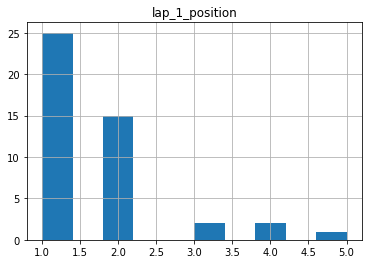

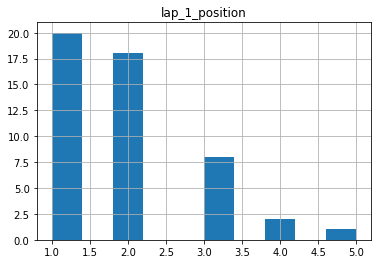

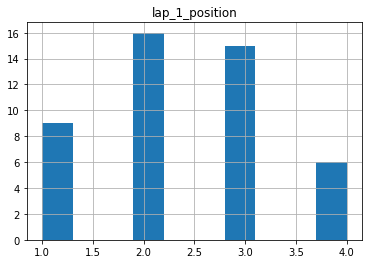

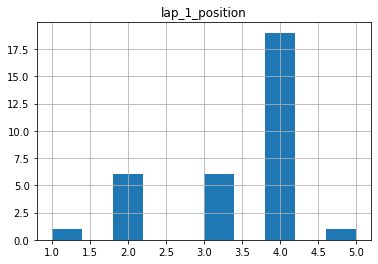

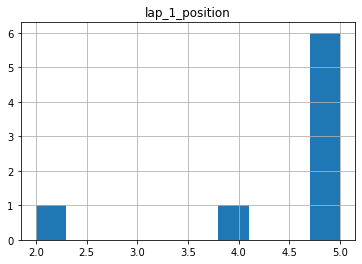

In [11]:
athlete_500m = athlete_races[athlete_races['event'] == '500m']
athlete_500m[['Start Pos.', 'lap_1_position']].groupby('Start Pos.').hist()

## Top Speed
Split based on whether the athlete was leading or following.

In [12]:
race_details_cols = list(athlete_races.columns[:16]) + ['instance_of_event_in_competition']
lap_details_cols = race_details_cols.copy()
lap_details_cols.extend(['lap', 'laptime', 'lap_start_position', 'lap_end_position', 'position_change'])
laptimes = pd.DataFrame(columns=lap_details_cols)

for index, athlete_race in athlete_races.iterrows():
    start_lap = 2 if athlete_race['event'] in ['500m', '1500m'] else 1
    for i in range(start_lap, 46):
        try:
            laptime = float(athlete_race[f'lap_{i}_laptime'])
        except Exception:
            laptime = np.nan
        
        # TODO use standard deviation to filter out erroneous laptimes instead of the 7.8 threshold
        if not np.isnan(laptime) and laptime > 7.8:
            lap_details = athlete_race[race_details_cols]
            lap_details['lap'] = i
            lap_details['laptime'] = laptime
            lap_details['lap_start_position'] = float(athlete_race[f'lap_{i - 1}_position']) if i > 1 else float(athlete_race['Start Pos.'])
            lap_details['lap_end_position'] = float(athlete_race[f'lap_{i}_position'])
            lap_details['position_change'] = (-1) * (lap_details['lap_end_position'] - lap_details['lap_start_position'])
            
            laptimes = laptimes.append(lap_details)

In [13]:
# fastest laptimes when leading
laptimes[laptimes['lap_end_position'] == 1]['laptime'].nsmallest(25).mean()

9.071480000000001

In [14]:
# fastest laptimes when following
laptimes[laptimes['lap_end_position'] != 1]['laptime'].nsmallest(25).mean()

8.86736

## Most Likely Lap to Pass

In [15]:
laptimes['lap'] = laptimes['lap'].astype('int')

C:\Users\ahale\Anaconda3\envs\shorttrack\lib\site-packages\pandas\plotting\_matplotlib\tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


event  position_change
1000m  -4.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -3.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -2.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -0.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        2.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        3.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1500m  -4.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -3.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -2.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -0.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        2.0               [[AxesSubplot

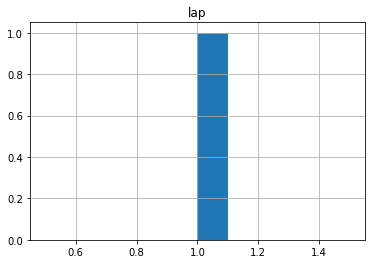

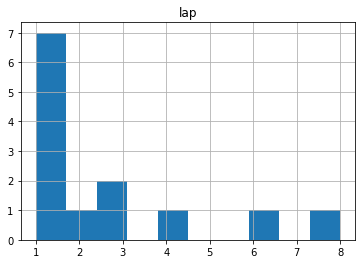

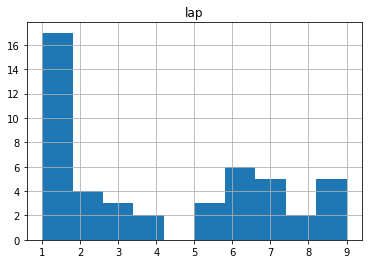

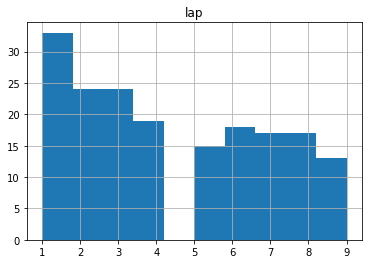

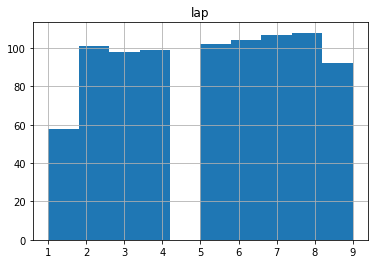

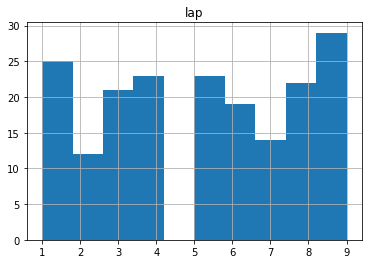

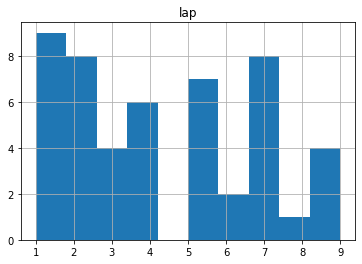

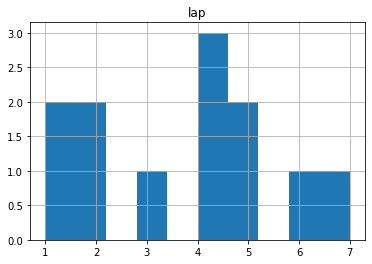

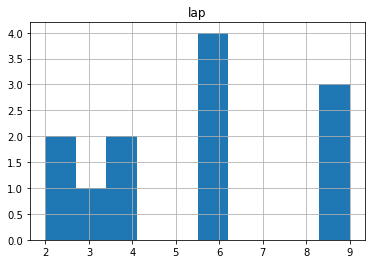

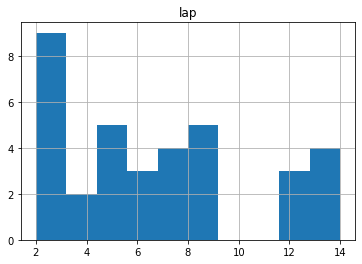

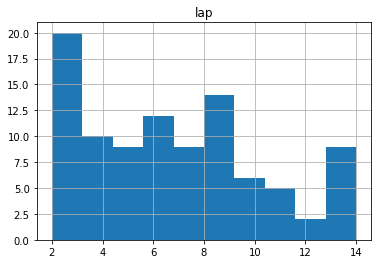

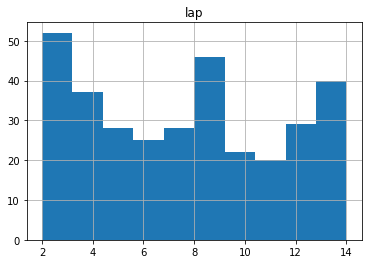

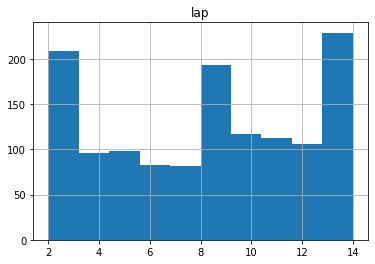

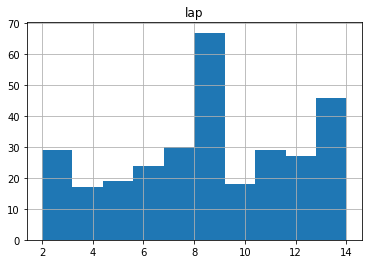

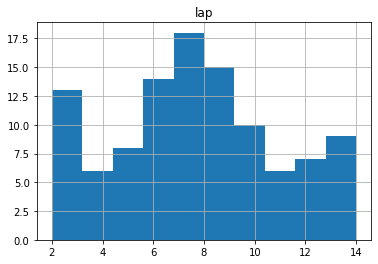

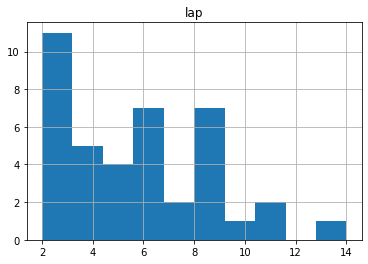

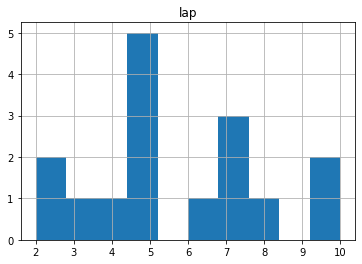

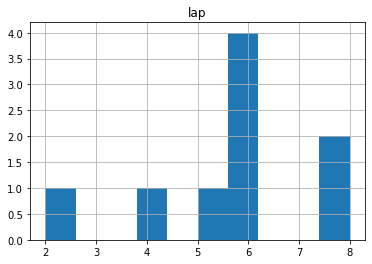

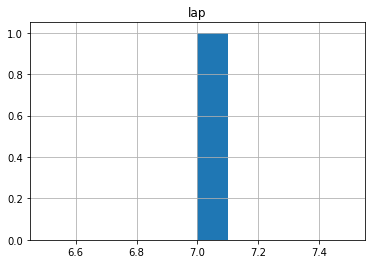

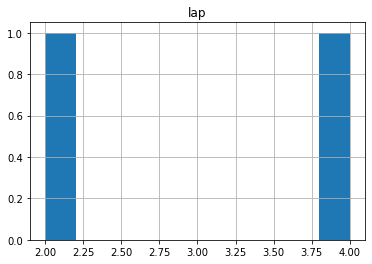

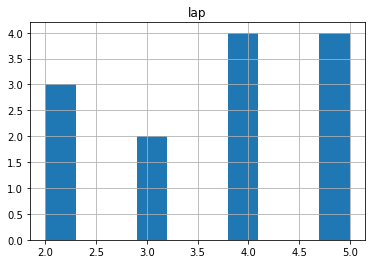

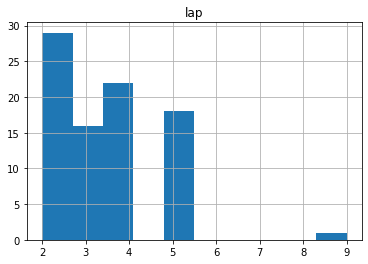

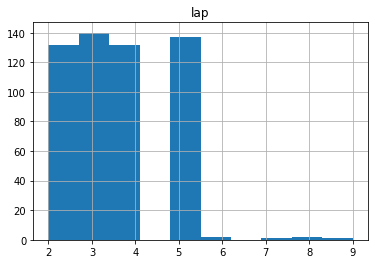

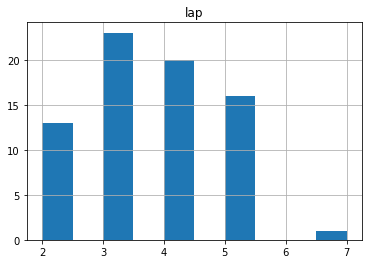

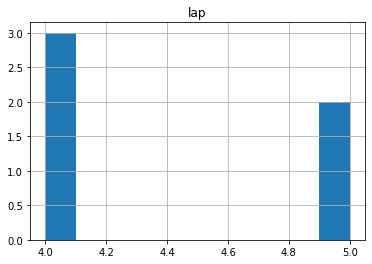

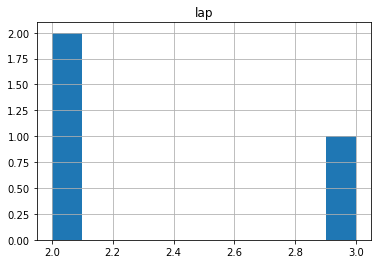

In [16]:
laptimes[['event', 'lap', 'position_change']].groupby(['event', 'position_change']).hist()

## x+y Position Selection
In a non-final race where multiple people advance, does the athlete typically try to finish in first or settle for a qualifying position?

event
1000m    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1500m    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
500m     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

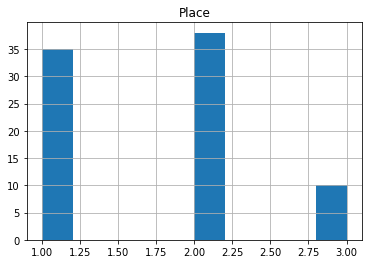

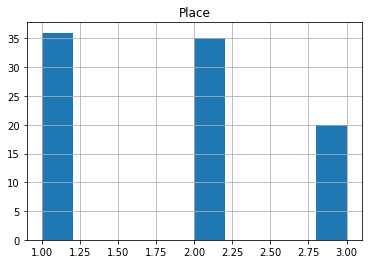

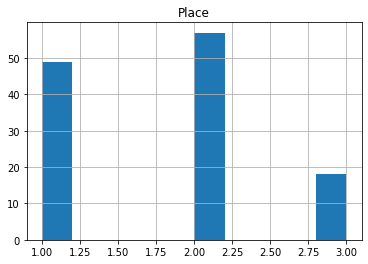

In [17]:
advancing_races = athlete_races[athlete_races['Qual.'].isin(['Q', 'q', 'QA', 'qA'])][['event', 'Place']]
advancing_races['Place'] = advancing_races['Place'].astype('int')
advancing_races.groupby('event').hist()

## 1500m Pacing - Leading Pace
When leading, does the athlete like to start the 1500m race at a fast pace or a slow pace?

In [18]:
laptimes[(laptimes['event'] == '1500m') & 
         (laptimes['lap'] > 1) & 
         (laptimes['lap'] < 5) & 
         (laptimes['lap_start_position'] == 1) &
         (laptimes['position_change'] == 0)]['laptime'].mean()

11.864944444444447

## 1500m Pacing - Pace Instigation
If following at the start of a 1500m race, does the athlete make a pass to the front to pick up the pace?

In [19]:
early_passes_to_front = laptimes[(laptimes['event'] == '1500m') & 
                                (laptimes['lap'] > 1) & 
                                (laptimes['lap'] < 5) & 
                                (laptimes['lap_start_position'] > 1) &
                                (laptimes['lap_end_position'] == 1)]

speed_up_sum = 0
denominator = len(early_passes_to_front)

for idx, early_pass in early_passes_to_front.iterrows():
    previous_laptime = laptimes[(laptimes['season'] == early_pass['season']) & 
                                (laptimes['competition'] == early_pass['competition']) & 
                                (laptimes['event'] == early_pass['event']) & 
                                (laptimes['gender'] == early_pass['gender']) &
                                (laptimes['round'] == early_pass['round']) &
                                (laptimes['race'] == early_pass['race']) &
                                (laptimes['instance_of_event_in_competition'] == early_pass['instance_of_event_in_competition']) &
                                (laptimes['lap'] == early_pass['lap'] - 1)]
    if len(previous_laptime):
        speed_up_sum += previous_laptime.iloc[0]['laptime'] - early_pass['laptime']
    else:
        denominator -= 1

print(speed_up_sum / denominator)

0.6634999999999999
